In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from utils import important_channels
import utils


In [51]:
raw_data = pd.read_csv('data/train/Data_S06_Sess01.csv')
feedback_times = raw_data[raw_data['FeedBackEvent'] == 1]['Time']
feedback_indices = feedback_times.index
fs = 200 # sampling frequency
default_channel = important_channels[0] # channel Cz

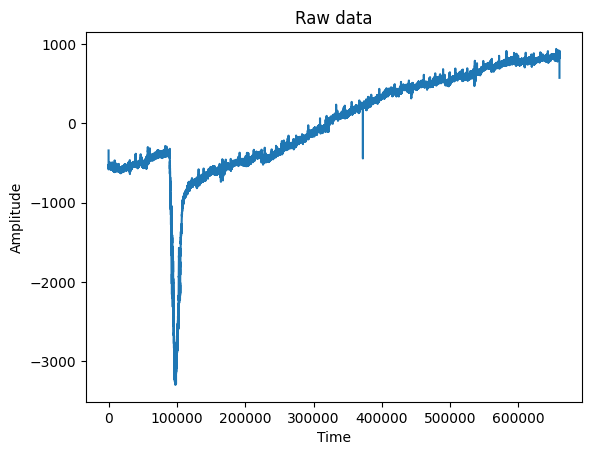

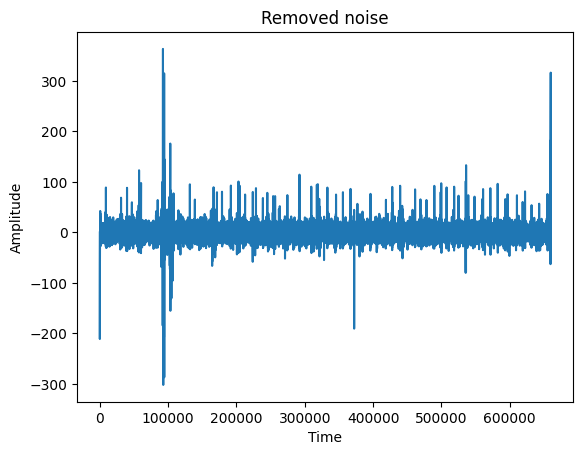

0          -0.053806
1        -105.988905
2        -180.806933
3        -211.092407
4        -206.037066
             ...    
131996    294.200442
131997    316.333843
131998    283.782546
131999    182.466744
132000     33.210205
Name: Cz, Length: 132001, dtype: float64


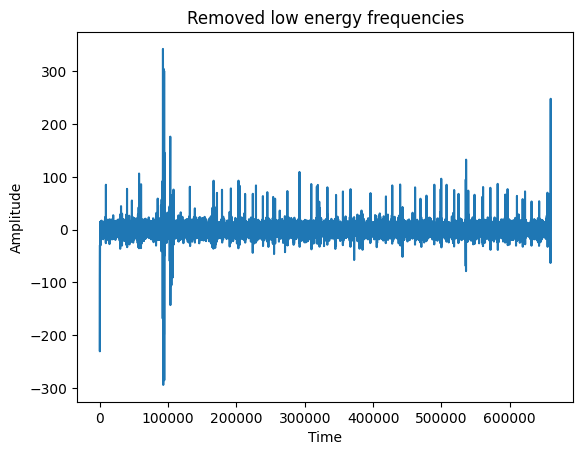

In [3]:
utils.plot_channel(raw_data, 0, default_channel, title='Raw data')

temp = utils.bandpass_filter_all(raw_data, highcut=30)
utils.plot_channel(temp, 0, default_channel, title='Removed noise')
print(temp[default_channel])
filtered_data = utils.bandpass_filter_all(temp, lowcut=0.2, highcut=10)
utils.plot_channel(filtered_data, 0, default_channel, title='Removed low energy frequencies')

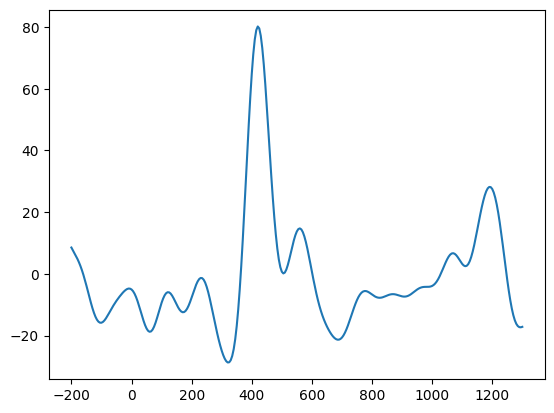

In [21]:
feedback_id = 30
part, t = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=feedback_id, before=0.2, after=1.3)
time = (part['Time'] - t) * 1000
'''for i in range(len(important_channels)):
    plt.plot(time, part[important_channels[i]])
'''
plt.plot(time, part[default_channel])
plt.show()

[14.74289616 28.1764726 ] 80.17201728013947
Latency: 0.42s


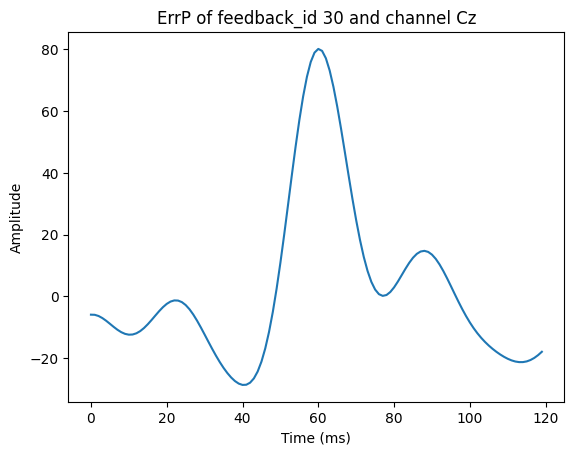

In [ ]:
# The criterion is stricter when n is lower and threshold higher
# 'n' is the maximum number of peaks that can be higher than the threshold
# 'threshold' is the ratio of the peak value to the max peak value
# 'lat_fix' should be equal to 'before' parameter of get_part_after_feedback function
def find_errp(np_signal, n=5, threshold=0.5, verbose=False, before=0.3, after=0.3, fs=200, lat_fix=0.2):
    peaks, _ = find_peaks(np_signal)
    peak_values = np_signal[peaks]
    peak_values = peak_values[peak_values > 0]

    max_peak = np.max(peak_values)
    peak_values = peak_values[peak_values != max_peak] # remove the max peak
    peak_values.sort() # sort peaks in ascending order
    peak_values = peak_values[-n:]
    if verbose: print(peak_values, max_peak)
    
    times = 0
    for v in peak_values:
        if (v / max_peak) >= threshold:
            times += 1

    peak_index = np.argmax(np_signal)
    T = 1/fs
    before_samples = int(before/T)
    after_samples = int(after/T) 

    latency = peak_index * T - lat_fix
    if verbose: print(f'Latency: {latency}s')

    return times < n, np_signal[peak_index - before_samples:peak_index + after_samples], latency

check, errp, _ = find_errp(part[default_channel].to_numpy(), n=2, threshold=0.7, verbose=True)
if check: utils.plot_signal(errp, title=f'ErrP of feedback_id {feedback_id} and channel {default_channel}')

In [35]:
N = len(feedback_times)

def calc_accuracy(n, threshold, verbose=True):
    counter = 0
    for i in range(N):
        part, _ = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=i, before=0.2, after=1.3)
        check, _, _ = find_errp(part[default_channel].to_numpy(), n=2, threshold=0.7)
        if check: counter += 1
    accuracy = counter/N
    if verbose: print(f'Accuracy: {accuracy*100}% ({counter}/{N})')
    return accuracy

calc_accuracy(2, 0.7)

Accuracy: 85.0% (51/60)


0.85

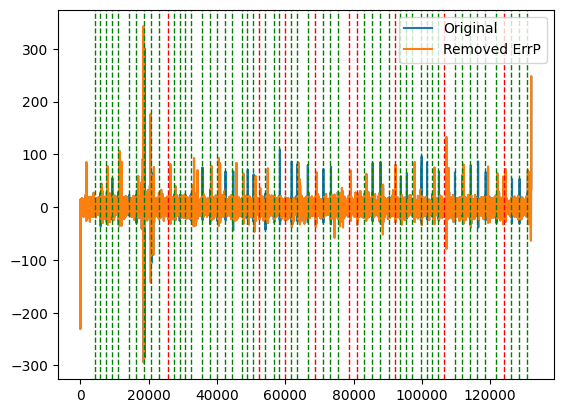

In [57]:
removed_errp = filtered_data.copy()
errp_indices = []
for i in range(N):
    part, t = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=i, before=0.2, after=1.3)
    check, errp, lat = find_errp(part[default_channel].to_numpy(), n=2, threshold=0.7)
    if check:
        #print(t, int(t*fs))
        removed_errp.loc[int(t*fs):int(t*fs)+len(part), default_channel] = 0
        errp_indices.append(i)

plt.plot(filtered_data[default_channel])
plt.plot(removed_errp[default_channel])
counter = 0
c = 'r'
for x_line in feedback_indices:
    if counter in errp_indices:
        c = 'g'
    else:
        c = 'r'
    plt.axvline(x=x_line, color=c, linestyle='--', linewidth=1, label=f"x={x_line}" if x_line == feedback_indices[0] else "")
    counter += 1

plt.legend(['Original', 'Removed ErrP'])
plt.show()